**Ex3 Multi-Class Text Classification in PyTorch using TorchText**

Students:

Sahar Israel - 205654536

Avi Bechavod - 200675981

Harel Yadaan - 207331125

video:
https://youtu.be/wFoRMcK-olU

***Steps to Implement the Model:***

1. install the latest version of TorchText:

In [1]:
!pip install torchtext==0.4


2. import all the required libraries:

In [24]:
import torch
import torchtext
from torchtext.datasets import text_classification
import os
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import time
from torch.utils.data.dataset import random_split
import re
from torchtext.data.utils import ngrams_iterator
from torchtext.data.utils import get_tokenizer
import matplotlib.pyplot as plt


3. define the ngrams and batch size:

In [3]:
NGRAMS =3
BATCH_SIZE = 16

 4. read the DBpedia dataset that is provided by the TorchText:

In [4]:
if not os.path.isdir('./.data'):
    os.mkdir('./.data')
train_dataset, test_dataset = text_classification.DATASETS['DBpedia'](
    root='./.data', ngrams=NGRAMS, vocab=None)

560000lines [01:35, 5845.17lines/s]
560000lines [02:50, 3276.50lines/s]
70000lines [00:21, 3319.95lines/s]


5. verify the length and the number of labels of the downloaded dataset:

In [5]:
print(len(train_dataset))
print(len(test_dataset))

560000
70000


In [6]:
print(len(train_dataset.get_labels()))
print(len(test_dataset.get_labels()))

14
14


6. use the CUDA architecture to speed-up the runtime and execution.

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

7. define the model for the classification.

In [8]:
class TextSentiment(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super().__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

#print(TextSentiment())

8. initialize the hyperparameters and define the function to generate the training batch:

In [9]:
VOCAB_SIZE = len(train_dataset.get_vocab())
EMBED_DIM = 32
NUN_CLASS = len(train_dataset.get_labels())
model = TextSentiment(VOCAB_SIZE, EMBED_DIM, NUN_CLASS).to(device)

def generate_batch(batch):
    label = torch.tensor([entry[0] for entry in batch])
    text = [entry[1] for entry in batch]
    offsets = [0] + [len(entry) for entry in text]
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text = torch.cat(text)
    return text, offsets, label

print(model)

TextSentiment(
  (embedding): EmbeddingBag(19008016, 32, mode=mean)
  (fc): Linear(in_features=32, out_features=14, bias=True)
)


9. define the function to train and test the model:

In [10]:
def train_func(sub_train_):

    # Train the model
    train_loss = 0
    train_acc = 0
    data = DataLoader(sub_train_, batch_size=BATCH_SIZE, shuffle=True,
                      collate_fn=generate_batch)
    for i, (text, offsets, cls) in enumerate(data):
        optimizer.zero_grad()
        text, offsets, cls = text.to(device), offsets.to(device), cls.to(device)
        output = model(text, offsets)
        loss = criterion(output, cls)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        train_acc += (output.argmax(1) == cls).sum().item()

    # Adjust the learning rate
    scheduler.step()

    return train_loss / len(sub_train_), train_acc / len(sub_train_)

def test(data_):
    loss = 0
    acc = 0
    data = DataLoader(data_, batch_size=BATCH_SIZE, collate_fn=generate_batch)
    for text, offsets, cls in data:
        text, offsets, cls = text.to(device), offsets.to(device), cls.to(device)
        with torch.no_grad():
            output = model(text, offsets)
            loss = criterion(output, cls)
            loss += loss.item()
            acc += (output.argmax(1) == cls).sum().item()

    return loss / len(data_), acc / len(data_)

10. train the model in 5 epochs:

In [11]:
N_EPOCHS = 5
min_valid_loss = float('inf')

criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=4.0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.9)

train_len = int(len(train_dataset) * 0.95)
sub_train_, sub_valid_ = \
    random_split(train_dataset, [train_len, len(train_dataset) - train_len])
history  =[]
for epoch in range(N_EPOCHS):

    start_time = time.time()
    train_loss, train_acc = train_func(sub_train_)
    valid_loss, valid_acc = test(sub_valid_)
    history+=[train_loss,valid_loss]
    secs = int(time.time() - start_time)
    mins = secs / 60
    secs = secs % 60

    print('Epoch: %d' %(epoch + 1), " | time in %d minutes, %d seconds" %(mins, secs))
    print(f'\tLoss: {train_loss:.4f}(train)\t|\tAcc: {train_acc * 100:.1f}%(train)')
    print(f'\tLoss: {valid_loss:.4f}(valid)\t|\tAcc: {valid_acc * 100:.1f}%(valid)')

Epoch: 1  | time in 3 minutes, 39 seconds
	Loss: 0.0098(train)	|	Acc: 95.6%(train)
	Loss: 0.0000(valid)	|	Acc: 98.0%(valid)
Epoch: 2  | time in 2 minutes, 48 seconds
	Loss: 0.0022(train)	|	Acc: 99.1%(train)
	Loss: 0.0000(valid)	|	Acc: 98.3%(valid)
Epoch: 3  | time in 2 minutes, 50 seconds
	Loss: 0.0010(train)	|	Acc: 99.7%(train)
	Loss: 0.0000(valid)	|	Acc: 98.3%(valid)
Epoch: 4  | time in 2 minutes, 49 seconds
	Loss: 0.0005(train)	|	Acc: 99.9%(train)
	Loss: 0.0000(valid)	|	Acc: 98.4%(valid)
Epoch: 5  | time in 2 minutes, 49 seconds
	Loss: 0.0003(train)	|	Acc: 100.0%(train)
	Loss: 0.0000(valid)	|	Acc: 98.4%(valid)


 11. test our model on the test data set and check the accuracy of the model:

In [12]:
print('Checking the results of test dataset...')
test_loss, test_acc = test(test_dataset)
print(f'\tLoss: {test_loss:.4f}(test)\t|\tAcc: {test_acc * 100:.1f}%(test)')

Checking the results of test dataset...
	Loss: 0.0000(test)	|	Acc: 94.7%(test)


12. test our model on individual news text strings and predict the class label for that given news text:

In [13]:
DBpedia_label = {0: 'Company',
                1: 'EducationalInstitution',
                2: 'Artist',
                3: 'Athlete',
                4: 'OfficeHolder',
                5: 'MeanOfTransportation',
                6: 'Building',
                7: 'NaturalPlace',
                8: 'Village',
                9: 'Animal',
                10: 'Plant',
                11: 'Album',
                12: 'Film',
                13: 'WrittenWork'}

def predict(text, model, vocab, ngrams):
    tokenizer = get_tokenizer("basic_english")
    with torch.no_grad():
        text = torch.tensor([vocab[token]
                            for token in ngrams_iterator(tokenizer(text), ngrams)])
        output = model(text, torch.tensor([0]))
        return output.argmax(1).item() + 1
vocab = train_dataset.get_vocab()
model = model.to("cpu")

13. we will take some random texts from the test data and check the predicted class label.

First prediction:

In [14]:
ex_text_str = "Brekke Church (Norwegian: Brekke kyrkje) is a parish church in Gulen Municipality in Sogn og Fjordane county, Norway. It is located in the village of Brekke. The church is part of the Brekke parish in the Nordhordland deanery in the Diocese of BjÃ¸rgvin. The white, wooden church, which has 390 seats, was consecrated on 19 November 1862 by the local Dean Thomas Erichsen. The architect Christian Henrik Grosch made the designs for the church, which is the third church on the site."

print("This is a %s class" %DBpedia_label[predict(ex_text_str, model, vocab, 2)])


This is a NaturalPlace class


Second Prediction:

In [15]:
ex_text_str2 = "Cerithiella superba is a species of very small sea snail, a marine gastropod mollusk in the family Newtoniellidae. This species is known from European waters. It was described by Thiele, 1912."

print("This text belongs to %s class" %DBpedia_label[predict(ex_text_str2, model, vocab, 2)])

This text belongs to Plant class


Third Prediction:

In [16]:
ex_text_str3 = "  Nithari is a village in the western part of the state of Uttar Pradesh India bordering on New Delhi. Nithari forms part of the New Okhla Industrial Development Authority's planned industrial city Noida falling in Sector 31. Nithari made international news headlines in December 2006 when the skeletons of a number of apparently murdered women and children were unearthed in the village."

print("This text belongs to %s class" %DBpedia_label[predict(ex_text_str3, model, vocab, 2)])


This text belongs to Animal class


**Our Predictions:**

First Prediction:

In [17]:

ex_text_str4 = " A frog is any member of a diverse and largely carnivorous group of short-bodied, tailless amphibians composing the order Anura."

print("This text belongs to %s class" %DBpedia_label[predict(ex_text_str4, model, vocab, 2)])

This text belongs to Plant class


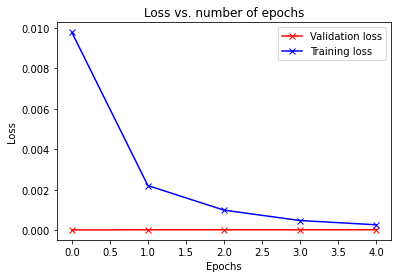

In [25]:
def plot_loss(histroy):
  train_loss =history[0:9:2]
  val_loss =history[1:10:2]
  plt.plot(val_loss, "-rx")
  plt.plot(train_loss, "-bx")
  plt.title("Loss vs. number of epochs")
  plt.legend(["Validation loss", "Training loss"])
  plt.xlabel("Epochs")
  plt.ylabel("Loss")

plot_loss(history)